In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib as matplotlib
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob


In [2]:
import warnings
warnings.filterwarnings('once')


## Read in FLUXNET data

In [3]:
# --------------------------------------
# Define data directory: 
# --------------------------------------
fluxnetDir   = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/FLUXNET2015/'

# --------------------------------------
# Get general site info
# --------------------------------------
siteInfoFile = fluxnetDir+'SiteList.csv'
# Now read that CSV file into a pandas dataframe 
siteInfoDF = pd.read_csv(siteInfoFile)

# Print out information available:
print('Available site characteristics (metadata) include: \n\n', siteInfoDF.columns.values, '\n')

# --------------------------------------
# And read in metadata for good measure
# --------------------------------------
metadataFile = fluxnetDir+'FLX_AA-Flx_BIF_ALL_20200501/FLX_AA-Flx_BIF_DD_20200501.xlsx'

# Read in that file 
metadataDF = pd.read_excel(metadataFile)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Available site characteristics (metadata) include: 

 ['SITE_ID' 'SITE_NAME' 'FLUXNET2015' 'FLUXNET-CH4' 'LOCATION_LAT'
 'LOCATION_LONG' 'LOCATION_ELEV' 'IGBP' 'MAT' 'MAP'] 



In [4]:
# --------------------------------------
# Get a list of all fluxnet data files
# --------------------------------------
dataFiles = glob.glob(fluxnetDir + 'FLX_*/*SUBSET_H?*')


In [5]:
# ------------------------------------------
# Define a function to read in FLUXNET data 
# ------------------------------------------

# --------------------------------------------------------
# Function to read requested variables from FLUXNET file. 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 
# Inputs:  fileName --> Full path to FLUXNET data file 
#          varNames --> An array of variable names to be 
#                       retrieved from said data file. 
#                       NOTE: If you wish to retrieve *all* 
#                       variables, pass the string 'ALL'. 
#          Note: varInfo found here
#                https://fluxnet.org/data/fluxnet2015-dataset/subset-data-product/
#  
# Outputs: fluxnetID --> ID string used to identify station
#          fluxnetDS --> An x-array dataset containing the 
#                        requested variables.
#                        Missing values will be set to NaN. 
# 
# --------------------------------------------------------

def readFLUXNET_var(fileName, varNames): 
    # Get ID of station 
    startID   = fileName.find('FLX_')
    fluxnetID = fileName[startID+4:startID+10]
    
    # print('Reading in site - ', fluxnetID)
    
    # Read in CSV file containing data 
    dataDF = pd.read_csv(fileName)
    
    # Return ALL variables from dataDF if requested
    if varNames=='ALL':
        fluxnetDF = dataDF
        
        # Set any value that's missing to NaN (not -999)
        fluxnetDF = fluxnetDF.replace(-9999, np.nan)

        
        # If time has been requested, reformat to pandas make index
        fluxnetDF['TIMESTAMP_START'] = pd.to_datetime(fluxnetDF['TIMESTAMP_START'].values, format='%Y%m%d%H%M')
        fluxnetDF = fluxnetDF.set_index(['TIMESTAMP_START'])
        
        # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
        fluxnetDS = fluxnetDF.to_xarray()
            
    # Reduce returned DF to contain only variables of interest  
    else:
        
        # Check that requested variables are available in specific file
        errCount = 0                       # Initialize flag for error 
        colNames = dataDF.columns.values   # Available variables in file 
        
        for iVar in range(len(varNames)):  # Check each variable individually
            if (varNames[iVar] in colNames)==False:
                # Turn on print statement for more verbose output
                # print('** ERROR: %13s   not contained in file for %8s  **' %(varNames[iVar], fluxnetID))
                
                # If any variable is not conatined in file, return a NaN 
                fluxnetDS = -999
                errCount  = errCount+1
                
        # If all the variables *are* available, isolate those in DF and return that
        if errCount == 0: 
            fluxnetDF = dataDF[varNames]
            
            # Set any value that's missing to NaN (not -999)
            fluxnetDF = fluxnetDF.replace(-9999, np.nan)
            
            # If time has been requested, reformat to pandas make index
            if ('TIMESTAMP_START' in varNames)==True:
                fluxnetDF['TIMESTAMP_START'] = pd.to_datetime(fluxnetDF['TIMESTAMP_START'].values, format='%Y%m%d%H%M')
                fluxnetDF = fluxnetDF.set_index(['TIMESTAMP_START'])
        
            # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
            fluxnetDS = fluxnetDF.to_xarray()
    
    return(fluxnetID, fluxnetDS)


In [6]:
# Define emtpy arrays to save stuff into 
startTime_fluxnet = np.full([len(dataFiles)], np.nan)
endTime_fluxnet   = np.full([len(dataFiles)], np.nan)
nMonths_fluxnet   = np.full([len(dataFiles)], np.nan)
# allStationID      = np.empty([len(dataFiles)]).astype(str)

# Variables I want returned:
varNames = ['TIMESTAMP_START','H_F_MDS','LE_F_MDS','WS_F','P_F','PA_F','TA_F']

# Loop over each station (data file)
for iStation in range(len(dataFiles)): 
    
    # Read in data 
    # ----------------------------------------------------------
    fluxnetID,fluxnetDS = readFLUXNET_var(dataFiles[iStation], varNames)
#     allStationID[iStation] = fluxnetID
    
    # Save lat and lon for this station 
    # ----------------------------------------------------------
    indStation  = np.where(fluxnetID==siteInfoDF['SITE_ID'])
    lat_fluxnet = siteInfoDF['LOCATION_LAT'].values[indStation]
    lon_fluxnet = siteInfoDF['LOCATION_LONG'].values[indStation]
    
    # Check that there was data saved for this particular site: 
    # ----------------------------------------------------------
    if (type(fluxnetDS)==int):
        print('No data for station: %8s' % fluxnetID)
    
    elif ( (np.all(np.isnan(fluxnetDS['H_F_MDS']))==True) | (np.all(np.isnan(fluxnetDS['WS_F']))==True) | (np.all(np.isnan(fluxnetDS['LE_F_MDS']))==True) ):
        print('No data for station (all Nan): %8s' % fluxnetID)
        
    # If data is present: 
    # ----------------------------------------------------------
    else:        
        # Only consider where data is actually present for selected vars
        iReal      = np.where((np.isfinite(fluxnetDS['LE_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['H_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['WS_F'])==True) & 
                              (np.isfinite(fluxnetDS['P_F'])==True) &
                              (np.isfinite(fluxnetDS['PA_F'])==True) &   
                              (np.isfinite(fluxnetDS['TA_F'])==True))[0]
        fluxnetDS  = fluxnetDS.isel(TIMESTAMP_START=iReal)
#         # Upsample to 3-hourly?
#         fluxnetDS = fluxnetDS.resample(TIMESTAMP_START='3H').mean()
        
        # Check how long data is available for and isolate JJA 
        # -----------------------------------------------------------
        startTime_fluxnet[iStation]  = fluxnetDS['TIMESTAMP_START'].values[0]
        endTime_fluxnet[iStation]    = fluxnetDS['TIMESTAMP_START'].values[-1]
        
        dateRange = pd.date_range(start=startTime_fluxnet[iStation],end=endTime_fluxnet[iStation],freq='M')
        nMonths_fluxnet[iStation] = len(dateRange)


In [7]:
# Check how many/which stations have enough years of data to be used, then
#    print some useful information on all that and 

iMinStart = np.where(startTime_fluxnet==np.nanmin(startTime_fluxnet))[0]
iMaxEnd   = np.where(endTime_fluxnet==np.nanmax(endTime_fluxnet))[0]

limYears = 5 
iStation_limYears = np.where(nMonths_fluxnet>=limYears*12)[0]

print('Number of stations with at least 5 years of data: ', len(iStation_limYears))
print()

print('Looking at every station available...')
print('Earliest start of data:    ', pd.DatetimeIndex(startTime_fluxnet[iMinStart])[0] )
print('Latest end of data:        ', pd.DatetimeIndex(endTime_fluxnet[iMaxEnd])[0] )

print()
del iMinStart
del iMaxEnd

startTime_fluxnet_sel = startTime_fluxnet[iStation_limYears]
endTime_fluxnet_sel   = endTime_fluxnet[iStation_limYears]

iMinStart = np.where(startTime_fluxnet_sel==np.nanmin(startTime_fluxnet_sel))[0]
iMaxEnd   = np.where(endTime_fluxnet_sel==np.nanmax(endTime_fluxnet_sel))[0]
print('Of stations with at least 5 years of data...')
print('Earliest start of data:    ', pd.DatetimeIndex(startTime_fluxnet_sel[iMinStart])[0] )
print('Latest end of data:        ', pd.DatetimeIndex(endTime_fluxnet_sel[iMaxEnd])[0] )



Number of stations with at least 5 years of data:  114

Looking at every station available...
Earliest start of data:     1992-01-01 00:00:00
Latest end of data:         2014-12-31 23:30:00

Of stations with at least 5 years of data...
Earliest start of data:     1992-01-01 00:00:00
Latest end of data:         2014-12-31 23:30:00


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# So let's filter stations to use just the ones that have at least 5 years of data 
#    (or whatever the limYears threshold is set to above...)
dataFiles_filter = np.squeeze(dataFiles)[iStation_limYears]

# Let's also figure out just how many days we'll need to create empty arrays for 
dayRange = pd.date_range(start=pd.DatetimeIndex(startTime_fluxnet_sel[iMinStart])[0],
                         end=pd.DatetimeIndex(endTime_fluxnet_sel[iMaxEnd])[0],
                         freq='30min')

# dayRange = pd.date_range(start=pd.DatetimeIndex(startTime_fluxnet_sel[iMinStart])[0],
#                          end=pd.DatetimeIndex(endTime_fluxnet_sel[iMaxEnd])[0],
#                          freq='3H')
nDays = len(dayRange)

print('Max number of days: ', nDays)

Max number of days:  403248


In [9]:
# Define emtpy arrays to save stuff into 
lat_fluxnet     = np.full([len(dataFiles_filter)], np.nan)
lon_fluxnet     = np.full([len(dataFiles_filter)], np.nan)
stationID       = np.empty([len(dataFiles_filter)]).astype(str)
fluxnet_SH      = np.full([len(dataFiles_filter), nDays], np.nan)    # H_F_MDS  [W/m2]
fluxnet_LH      = np.full([len(dataFiles_filter), nDays], np.nan)    # LE_F_MDS [W/m2] 
fluxnet_spd     = np.full([len(dataFiles_filter), nDays], np.nan)    # WS_F     [m/s]
fluxnet_precip  = np.full([len(dataFiles_filter), nDays], np.nan)    # P_F      [mm/day - summed from half/hourly for daily data]
fluxnet_pressr  = np.full([len(dataFiles_filter), nDays], np.nan)    # PA_F     [kPa] -- seriously? kPa? 
fluxnet_temp    = np.full([len(dataFiles_filter), nDays], np.nan)    # TA_F     [deg C]

# Variables I want returned:
varNames = ['TIMESTAMP_START','H_F_MDS','LE_F_MDS','WS_F','P_F','PA_F','TA_F']

# Loop over each station (data file)
for iStation in range(len(dataFiles_filter)):
    
    # Read in data 
    # ----------------------------------------------------------
    fluxnetID,fluxnetDS = readFLUXNET_var(dataFiles_filter[iStation], varNames)
    
    # Save lat and lon for this station 
    # ----------------------------------------------------------
    indStation            = np.where(fluxnetID==siteInfoDF['SITE_ID'])
    lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
    lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
    stationID[iStation]   = fluxnetID
    
    # Check that there was data saved for this particular site: 
    # ----------------------------------------------------------
    if (type(fluxnetDS)==int):
        print('No data for station: %8s' % fluxnetID)
    
    elif ( (np.all(np.isnan(fluxnetDS['H_F_MDS']))==True) | (np.all(np.isnan(fluxnetDS['WS_F']))==True) | (np.all(np.isnan(fluxnetDS['LE_F_MDS']))==True) ):
        print('No data for station: %8s' % fluxnetID)
        
    # If data is present: 
    # ----------------------------------------------------------
    else:        
        # Only consider where data is actually present for selected vars
        iReal      = np.where((np.isfinite(fluxnetDS['LE_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['H_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['WS_F'])==True) & 
                              (np.isfinite(fluxnetDS['P_F'])==True) &
                              (np.isfinite(fluxnetDS['PA_F'])==True) &   
                              (np.isfinite(fluxnetDS['TA_F'])==True))[0]
        fluxnetDS  = fluxnetDS.isel(TIMESTAMP_START=iReal)
 
        
        # Check where to save data in time arrays 
        # -----------------------------------------------------------
        startTime_fluxnet = pd.DatetimeIndex(fluxnetDS['TIMESTAMP_START'].values)[0]
        endTime_fluxnet   = pd.DatetimeIndex(fluxnetDS['TIMESTAMP_START'].values)[-1]
        
        iTime_start = int(np.where(startTime_fluxnet==dayRange)[0])
        iTime_end   = int(np.where(endTime_fluxnet==dayRange)[0])
        
#         # Upsample to 3-hourly?
#         fluxnetDS=fluxnetDS.resample(TIMESTAMP_START='3H').mean()
        
        # If any 30-minute period is missing, fill it in with NaN's but keep a row present for it 
        fluxnetDS = fluxnetDS.reindex({'TIMESTAMP_START': dayRange[iTime_start:(iTime_end+1)]})
       
        # Save timeseries of each variable out to arrays 
        # -----------------------------------------------------------
        fluxnet_SH[iStation,iTime_start:(iTime_end+1)]     = fluxnetDS['H_F_MDS'].values
        fluxnet_LH[iStation,iTime_start:(iTime_end+1)]     = fluxnetDS['LE_F_MDS'].values
        fluxnet_spd[iStation,iTime_start:(iTime_end+1)]    = fluxnetDS['WS_F'].values
        fluxnet_precip[iStation,iTime_start:(iTime_end+1)] = fluxnetDS['P_F'].values
        fluxnet_pressr[iStation,iTime_start:(iTime_end+1)] = fluxnetDS['PA_F'].values
        fluxnet_temp[iStation,iTime_start:(iTime_end+1)]   = fluxnetDS['TA_F'].values
        

**Uncomment below to average up to three hourly**<br>
The issue with this is that everything's in local time. The model only outputs every three hours in *UTC* time, so the hours wouldn't match up with the three hourly averaged FLUXNET data if averaging were constant. So keep it in hourly for now, then get just the hours that match later. 

**UPDATE**: Upsample to *hourly*, not thirty minutes

In [10]:
# Upsample to hourly 
fluxnetSH_DS = xr.DataArray(fluxnet_SH, coords=[stationID, dayRange], dims=['stationID','time'])
fluxnetLH_DS = xr.DataArray(fluxnet_LH, coords=[stationID, dayRange], dims=['stationID','time'])
fluxnetSpd_DS = xr.DataArray(fluxnet_spd, coords=[stationID, dayRange], dims=['stationID','time'])
fluxnetPrec_DS = xr.DataArray(fluxnet_precip, coords=[stationID, dayRange], dims=['stationID','time'])
fluxnetTemp_DS = xr.DataArray(fluxnet_temp, coords=[stationID, dayRange], dims=['stationID','time'])

print('Starting to get 1-hour means (sum for precip)')
fluxnet_SH     = fluxnetSH_DS.resample(time='1H').mean()
fluxnet_LH     = fluxnetLH_DS.resample(time='1H').mean()
fluxnet_spd    = fluxnetSpd_DS.resample(time='1H').mean()
fluxnet_precip = fluxnetPrec_DS.resample(time='1H').sum()
fluxnet_temp   = fluxnetTemp_DS.resample(time='1H').mean()

# Fill in NaN's for precip anywhere there should be one (based on whether or not SH has data)
#   If not, xarray is filling these with zeros and it's throwing things off later. 
# fluxnet_precip[np.where(np.isnan(fluxnet_SH)==True)[0]] = np.nan


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Starting to get 1-hour means (sum for precip)


In [11]:
#Fill in NaN's for precip anywhere there should be one (based on whether or not SH has data)
#   If not, xarray is filling these with zeros and it's throwing things off later. 

for iStation in range(len(stationID)):
    indNan=np.where(np.isnan(fluxnet_SH[iStation,:])==True)[0]
    fluxnet_precip[iStation,indNan] = np.nan


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Set day range to 3-hour intervals too 
dayRange = pd.date_range(start=pd.DatetimeIndex(startTime_fluxnet_sel[iMinStart])[0],
                         end=pd.DatetimeIndex(endTime_fluxnet_sel[iMaxEnd])[0],
                         freq='1H')
nDays = len(dayRange)
len(dayRange)

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


201624

In [13]:
# Remove from record if it's Feb. 29th (i.e., skip leap years )
# -------------------------------------------------------------

# Indices to skip 
iSkips = np.where((dayRange.month==2) & (dayRange.day==29))[0]
print('Number of days before deletes: ', len(dayRange))

dayRange       = np.delete(dayRange,iSkips)
fluxnet_SH     = np.delete(fluxnet_SH,iSkips,axis=1)
fluxnet_LH     = np.delete(fluxnet_LH,iSkips,axis=1)
fluxnet_spd    = np.delete(fluxnet_spd,iSkips,axis=1)
fluxnet_precip = np.delete(fluxnet_precip,iSkips,axis=1)
fluxnet_pressr = np.delete(fluxnet_pressr,iSkips,axis=1)
fluxnet_temp   = np.delete(fluxnet_temp,iSkips,axis=1)

print('Number of days after deletes: ', len(dayRange))


Number of days before deletes:  201624
Number of days after deletes:  201480


In [13]:
# ## Save station lat/lon to pickle file 

# fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/FLUXNET_lat.p'
# with open(fileName, "wb") as f:
#     pickle.dump(lat_fluxnet, f)

# fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/FLUXNET_lon.p'
# with open(fileName, "wb") as f:
#     pickle.dump(lon_fluxnet, f)


In [14]:
# # Also save out station ID
# fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/FLUXNET_stationID.p'
# with open(fileName, "wb") as f:
#     pickle.dump(stationID, f)
    

## Read in model data (3-hourly) at same sites

In [14]:
dataPath = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/3hr_IslaSims/processed_3hourCESMatFLUXNETstations.nc'
modelDS  = xr.open_dataset(dataPath, decode_times=True)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Slightly refined which stations to use above, so filter for consistency here 
listMatch = []

for iStation in range(len(stationID)): 
    iList = np.where(modelDS.station.values==stationID[iStation])[0]
    
    if len(iList)>0:
        listMatch.append(iList[0])
        
modelDS = modelDS.isel(station=listMatch)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
# FLUXNET obs are in local time. So read in their time zone and convert model to it (currently UTC)
fileName = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/FLUXNET2015/FLX_AA-Flx_BIF_ALL_20200501/FLX_AA-Flx_BIF_DD_20200501.xlsx'
metaDS   = pd.read_excel(fileName)  

# Get fluxnet UTC time offset
utc_offset = np.empty([len(stationID)]).astype(str)

for iStation in range(len(stationID)):
    selStation = stationID[iStation]
    iLoc=np.where((metaDS['SITE_ID']==selStation) & (metaDS['VARIABLE_GROUP']=='GRP_UTC_OFFSET'))[0]
    utc_offset[iStation] = str((metaDS['DATAVALUE'].values[iLoc])[0])

# Apply offset to each station in the model 
modelTimes_pd = pd.DatetimeIndex(modelDS.time.values, tz='UTC')

modelTimes_local = np.empty([len(stationID),len(modelTimes_pd)])
for iStation in range(len(stationID)):
    modelTimes_local[iStation,:] = modelTimes_pd+pd.DateOffset(hours=float(utc_offset[iStation]))
    
    # Remove leap years again, since shifiting in time can cause issue
    iLeap = np.where((pd.DatetimeIndex(modelTimes_local[iStation,:]).month==2) & (pd.DatetimeIndex(modelTimes_local[iStation,:]).day==29))
    modelTimes_local[iStation,iLeap] = np.nan

modelTimes_local = pd.DatetimeIndex(modelTimes_local)



In [170]:
print(modelTimes_pd[0:10])
print(modelTimes_local[1,0:10])

DatetimeIndex(['2000-01-01 00:00:00+00:00', '2000-01-01 03:00:00+00:00',
               '2000-01-01 06:00:00+00:00', '2000-01-01 09:00:00+00:00',
               '2000-01-01 12:00:00+00:00', '2000-01-01 15:00:00+00:00',
               '2000-01-01 18:00:00+00:00', '2000-01-01 21:00:00+00:00',
               '2000-01-02 00:00:00+00:00', '2000-01-02 03:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)
DatetimeIndex(['2000-01-01 01:00:00', '2000-01-01 04:00:00',
               '2000-01-01 07:00:00', '2000-01-01 10:00:00',
               '2000-01-01 13:00:00', '2000-01-01 16:00:00',
               '2000-01-01 19:00:00', '2000-01-01 22:00:00',
               '2000-01-02 01:00:00', '2000-01-02 04:00:00'],
              dtype='datetime64[ns]', freq=None)


In [167]:
modelHours  = np.unique(modelTimes_local[14,:].hour)
print(modelHours)
modelHours  = modelHours[np.isfinite(modelHours)==True]
print(modelHours)

[ 0.  3.  6.  9. 12. 15. 18. 21. nan nan nan nan nan nan nan nan]
[ 0.  3.  6.  9. 12. 15. 18. 21.]


In [115]:
# Match up fluxnet hourly obs to the hours that are in the model per station 
fluxnet_time_match = np.full([len(stationID), int(len(dayRange)/3)], np.nan)

fluxnet_SH_match = np.full([len(stationID), int(len(dayRange)/3)], np.nan)
fluxnet_LH_match = np.full([len(stationID), int(len(dayRange)/3)], np.nan)


for iStation in range(len(stationID)):
    modelHours  = np.unique(modelTimes_local[iStation,:].hour)
    modelHours  = modelHours[np.isfinite(modelHours)==True]
    
    # Get indices that match *all* of those hours
    matchInds = []
    for iHour in range(len(modelHours)):
        imatchHours = np.where(dayRange.hour==modelHours[iHour])[0]

        matchInds.append(imatchHours)

    matchInds = np.reshape(matchInds,[np.shape(matchInds)[0]*np.shape(matchInds)[1]])
    matchInds = np.sort(matchInds)
    
    # Now select just those indices in fluxnet data 
    fluxnet_time_match[iStation,:] = dayRange[matchInds]
    fluxnet_SH_match[iStation,:]   = fluxnet_SH[iStation,matchInds]
    fluxnet_LH_match[iStation,:]   = fluxnet_LH[iStation,matchInds]



In [75]:
# Precip saved in m/s for model data. Ideally, let's just work in mm/day. 
#   Multiply by number of seconds in 3 hours (dT) and by 1000 to convert to mm
modelPrecip_mm = modelDS.model_precip.values*(3.0*60.0*60.0)*1000.0
modelDS['modelPrecip_mm'] = (('station','time'), modelPrecip_mm)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Classify days via precipitation

In [19]:
# Get daily rain totals for model/fluxnet sites
fluxnetPrec_DS = xr.DataArray(fluxnet_precip, coords=[stationID, dayRange], dims=['stationID','time'])
rainDaily_fluxnet = fluxnetPrec_DS.resample(time='1D').sum()

rainDaily_model = modelDS['modelPrecip_mm'].resample(time='1D').sum()


In [20]:
#Fill in NaN's for precip anywhere there should be one (based on whether or not SH has data)
#   If not, xarray is filling these with zeros and it's throwing things off later. 
fluxnetSH_DS = xr.DataArray(fluxnet_SH, coords=[stationID, dayRange], dims=['stationID','time'])
shDaily_fluxnet = fluxnetSH_DS.resample(time='1D').mean()

for iStation in range(len(stationID)):
    indNan=np.where(np.isnan(shDaily_fluxnet[iStation,:])==True)[0]
    rainDaily_fluxnet[iStation,indNan] = np.nan


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
## Step 1: What should the threshold be for a "wet" day? Should it vary by station? 
# Could try 3 mm, in line with Burns et al...  

minWet = 3

pctWetDays_obs   = np.full([len(stationID)], np.nan)
pctWetDays_model = np.full([len(stationID)], np.nan)
for iStation in range(len(stationID)):
    pctWetDays_obs[iStation]   = len(np.where(rainDaily_fluxnet[iStation,:]>=minWet)[0])/len(np.where(np.isfinite(rainDaily_fluxnet[iStation,:])==True)[0])
    pctWetDays_model[iStation] = len(np.where(rainDaily_model[iStation,:]>=minWet)[0])/len(np.where(np.isfinite(rainDaily_model[iStation,:])==True)[0])
    
    # Just to double check that the order is consistent between model and obs 
    if (modelDS.station.values[iStation]!=stationID[iStation]):
        print(modelDS.station.values[iStation], '  ', stationID[iStation])
    

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'FLUXNET: Percent days classified as wet by station')

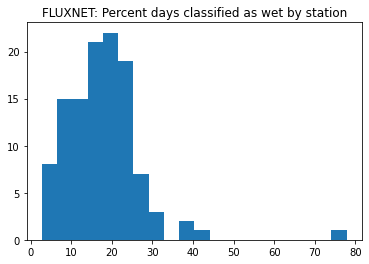

In [22]:
plt.hist(pctWetDays_obs*100,20)
plt.title('FLUXNET: Percent days classified as wet by station')


Text(0.5, 1.0, 'Model: Percent days classified as wet by station')

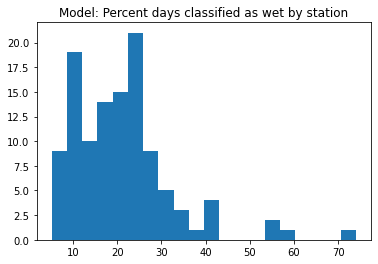

In [32]:
plt.hist(pctWetDays_model*100,20)
plt.title('Model: Percent days classified as wet by station')

In [23]:
'''
Function to send back which classification each day falls into, 
based on precipitation amount, similar to Burns et al. (2015; 2018).
This version of the function assumes a single column run/input, 
in that only one dimension exists for precip. 

Inputs: 
   time:   An array of times to worry about. 
           Should be a pandas datetime.
   precip: Daily precipitation (summed). Units can be in mm or m, 
           but need to be consistent with the threshold the user
           defines (i.e., no unit conversions done here).
   wetDef: User-defined threshold for defining days as wet vs. dry. 
Outputs:
    classificationArr: Array with one fewer length than time, where
                       the classification falls into four categories:
                       1 :: wWet   (wet day following a wet day)
                       2 :: wDry   (dry day following a wet day)
                       3 :: dWet   (wet day following a dry day)
                       4 :: dDry   (dry day following a dry day)
                       
                       Difference in length due to the first day not having a 
                       "before" day to reference. So time[0] on the 
                       classification array corresponds to time[1]. 

'''

def classifyPrectDays_SCAM(time,precip,wetDef): 
    
    # Define empty arrays of the appropriate length
    nTimes               = len(time)
    classificationArr    = np.empty([len(time)]).astype('str')
    
    for iDay in range(nTimes-1): 
        
        # Wet day...
        if precip[iDay]>=wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'wWet'  # Wet day following wet 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'wDry' # Dry day following wet 
        # Dry day...
        elif precip[iDay]<wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'dWet'  # Wet day following dry 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'dDry' # Dry day following dry 
        # If missing...
        else: 
            classificationArr[iDay+1] = 'nan'

    return(classificationArr[1::])



In [27]:
# # Get classification of all days... 
# nDays_obs   = len(rainDaily_fluxnet.time.values)
# nDays_model = len(rainDaily_model.time.values)

# dayClass_obs   = np.empty([len(stationID), nDays_obs]).astype(str)
# dayClass_model = np.empty([len(stationID), nDays_model]).astype(str)

# for iStation in range(len(stationID)):
#     dayClass_obs[iStation,1::]   = classifyPrectDays_SCAM(rainDaily_fluxnet.time.values, rainDaily_fluxnet[iStation,:], minWet)
#     dayClass_model[iStation,1::] = classifyPrectDays_SCAM(rainDaily_model.time.values, rainDaily_model[iStation,:], minWet)


In [28]:
# # Fill in first spot with 'nan' (since it's missing anyway)
# dayClass_obs[:,0] = np.nan
# dayClass_model[:,0] = np.nan


In [29]:
dayClass_obs[10,:]

array(['nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan'], dtype='<U32')

In [30]:
# # Save out to pickle file? 

# fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/fluxnet_dailyPrecipClassification.p'
# with open(fileName, "wb") as f:
#     pickle.dump(dayClass_obs, f)

# fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/model_dailyPrecipClassification.p'
# with open(fileName, "wb") as f:
#     pickle.dump(dayClass_model, f)


In [71]:
# Read in from pickle file: 
fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/fluxnet_dailyPrecipClassification.p'
with open(fileName, "rb") as f:
    dayClass_obs = pickle.load(f)

fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/model_dailyPrecipClassification.p'
with open(fileName, "rb") as f:
    dayClass_model = pickle.load(f)
    

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
dayClass_obs[10,:]

array(['nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan'], dtype='<U32')

In [33]:
## Remove leap year days (Feb 29th)
obsTime_daily   = pd.DatetimeIndex(rainDaily_fluxnet.time.values)
modelTime_daily =pd.DatetimeIndex(rainDaily_model.time.values)

# Where is it Feb 29th?
iSkips          = np.where((obsTime_daily.month==2) & (obsTime_daily.day==29))[0]
dayClass_obsSel = np.delete(dayClass_obs,iSkips,axis=1)

iSkipsModel       = np.where((modelTime_daily.month==2) & (modelTime_daily.day==29))[0]
dayClass_modelSel = np.delete(dayClass_model,iSkipsModel,axis=1)


In [34]:
np.shape(dayClass_modelSel)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(114, 5476)

## Look at flux biases based on day classification 

In [130]:
'''
Function to split up an input array
into day/hour.

Inputs:  Time should be a pandas datetime array. 
         Var should be a 2d array, location x time.
         MODIFIED: just 1d array [time]
Outputs: Output will be station by days by hours.

'''

def var_separateTime(time,var):
    
    #nLoc = int(np.shape(var)[0])
    
    # Get arrays of unique years/months/days/hours 
    startDay = datetime.date(int(time.year[0]), int(time.month[0]), int(time.day[0]))
    var_separate = np.full([1,8], np.nan)  # Initialize array to hold daily data 
    
    # Counter for number of days to split things into
    dayCheck = 0 
    while np.isfinite(dayCheck)==True:
        iDay    = np.where((time.year==startDay.year)  & 
                           (time.month==startDay.month) &
                           (time.day==startDay.day))[0]
        
        if len(iDay)>=1:
            timeDay = time[iDay]
            varDay  = var[iDay]

            # Initialize array to hold 3-hourly values
            hourlyVars = np.full([8],np.nan)
            hourValues = np.unique(time.hour)
            hourValues  = hourValues[np.isfinite(hourValues)==True]

            for iHr in range(len(hourValues)):
                selHour = np.where(timeDay.hour==hourValues[iHr])[0]

                # Check if not already in hourly form
#                 if len(selHour)>1: 
#                     varHour = np.nanmean(varDay[:, selHour])
                if len(selHour)<1:
                    varHour = np.nan
                else:
                    varHour = varDay[selHour]   
                    
                # Fill in var_separateTime by day/hour
                hourlyVars[iHr] = np.squeeze(varHour)

            # Add to a daily array 
            if dayCheck==0:
                var_separate[0, :] = hourlyVars
            else:
                #np.concatenate((var_separate, hourlyVars[:,None]),axis=0)
                var_separate = np.append(var_separate, np.reshape(hourlyVars,[1,8]), axis=0)
            
            # Set next day 
            startDay = startDay+datetime.timedelta(days=1)
            dayCheck = dayCheck+1
        elif ((startDay.month==2) & (startDay.day==29)):
            # Set next day 
            startDay = startDay+datetime.timedelta(days=1)
            #dayCheck = dayCheck+1
            #print('Skipping a leap year...')
        else: 
            dayCheck = np.nan
    
    return(var_separate)

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [131]:
# modelDaily_SH = np.full([len(stationID), int(np.ceil(len(modelTimes_local[10,:])/8)), 8], np.nan)
# modelDaily_LH = np.full([len(stationID), int(np.ceil(len(modelTimes_local[10,:])/8)), 8], np.nan)

# for iStation in range(len(stationID)):

#     # Get model data separated by day/hour 
#     modelDaily_SH[iStation,:,:] = var_separateTime(modelTimes_local[iStation,:], modelDS.model_SH.values[iStation,:])
    
#     modelDaily_LH[iStation,:,:] = var_separateTime(modelTimes_local[iStation,:], modelDS.model_LH.values[iStation,:])

#     print('Done with station %i' % (iStation+1))
    

Done with station 1
Done with station 2
Done with station 3
Done with station 4
Done with station 5
Done with station 6
Done with station 7
Done with station 8
Done with station 9
Done with station 10
Done with station 11
Done with station 12
Done with station 13
Done with station 14
Done with station 15
Done with station 16
Done with station 17
Done with station 18
Done with station 19
Done with station 20
Done with station 21
Done with station 22
Done with station 23
Done with station 24
Done with station 25
Done with station 26
Done with station 27
Done with station 28
Done with station 29
Done with station 30
Done with station 31
Done with station 32
Done with station 33
Done with station 34
Done with station 35
Done with station 36
Done with station 37
Done with station 38
Done with station 39
Done with station 40
Done with station 41
Done with station 42
Done with station 43
Done with station 44
Done with station 45
Done with station 46
Done with station 47
Done with station 48
D

In [133]:
meanSH_model = np.nanmean(modelDaily_SH,axis=1)



In [137]:
np.unique(modelTimes_local[22,:].hour)

array([ 1,  4,  7, 10, 13, 16, 19, 22])

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


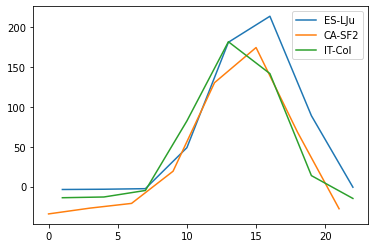

In [141]:
plt.plot(np.unique(modelTimes_local[3,:].hour)[0:8], meanSH_model[3,:],label=stationID[3])
plt.plot(np.unique(modelTimes_local[10,:].hour)[0:8], meanSH_model[10,:],label=stationID[10])
plt.plot(np.unique(modelTimes_local[53,:].hour)[0:8], meanSH_model[53,:],label=stationID[53])
plt.legend()


In [142]:
# # Save out to pickle file? 

# fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/model_dailySH.p'
# with open(fileName, "wb") as f:
#     pickle.dump(modelDaily_SH, f)

# fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/model_dailyLH.p'
# with open(fileName, "wb") as f:
#     pickle.dump(modelDaily_LH, f)



/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [154]:
# fluxnetDaily_SH = np.full([len(stationID), int(np.ceil(len(fluxnet_time_match[10,:])/8)), 8], np.nan)
# fluxnetDaily_LH = np.full([len(stationID), int(np.ceil(len(fluxnet_time_match[10,:])/8)), 8], np.nan)

# fluxnet_time_match = pd.DatetimeIndex(fluxnet_time_match)

# for iStation in range(len(stationID)):

#     # Get fluxnet data separated by day/hour 
#     fluxnetDaily_SH[iStation,:,:] = var_separateTime(fluxnet_time_match[iStation,:], fluxnet_SH_match[iStation,:])
    
#     fluxnetDaily_LH[iStation,:,:] = var_separateTime(fluxnet_time_match[iStation,:], fluxnet_LH_match[iStation,:])

#     print('Done with station %i' % (iStation+1))
    

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Done with station 1
Done with station 2
Done with station 3
Done with station 4
Done with station 5
Done with station 6
Done with station 7
Done with station 8
Done with station 9
Done with station 10
Done with station 11
Done with station 12
Done with station 13
Done with station 14
Done with station 15
Done with station 16
Done with station 17
Done with station 18
Done with station 19
Done with station 20
Done with station 21
Done with station 22
Done with station 23
Done with station 24
Done with station 25
Done with station 26
Done with station 27
Done with station 28
Done with station 29
Done with station 30
Done with station 31
Done with station 32
Done with station 33
Done with station 34
Done with station 35
Done with station 36
Done with station 37
Done with station 38
Done with station 39
Done with station 40
Done with station 41
Done with station 42
Done with station 43
Done with station 44
Done with station 45
Done with station 46
Done with station 47
Done with station 48
D

In [155]:
# # Save out to pickle file? 

# fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/fluxnet_dailySH.p'
# with open(fileName, "wb") as f:
#     pickle.dump(fluxnetDaily_SH, f)

# fileName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/fluxnet_dailyLH.p'
# with open(fileName, "wb") as f:
#     pickle.dump(fluxnetDaily_LH, f)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [156]:
# Check that the dimensions all work out
print('Dimensions for model data:')
print(np.shape(modelDaily_SH))
print(np.shape(dayClass_modelSel))

print('\nDimensions for fluxnet data:')
print(np.shape(fluxnetDaily_SH))
print(np.shape(dayClass_obsSel))


Dimensions for model data:
(114, 5476, 8)
(114, 5476)

Dimensions for fluxnet data:
(114, 8395, 8)
(114, 8395)


In [157]:
# Compute EF ahead of time...
modelDaily_EF   = modelDaily_LH/(modelDaily_SH+modelDaily_LH)
fluxnetDaily_EF = fluxnetDaily_LH/(fluxnetDaily_SH+fluxnetDaily_LH)



<ipython-input-157-e758a30aa155>:3: RuntimeWarning: divide by zero encountered in true_divide
  fluxnetDaily_EF = fluxnetDaily_LH/(fluxnetDaily_SH+fluxnetDaily_LH)
<ipython-input-157-e758a30aa155>:3: RuntimeWarning: invalid value encountered in true_divide
  fluxnetDaily_EF = fluxnetDaily_LH/(fluxnetDaily_SH+fluxnetDaily_LH)


In [158]:
# Now get means for each rain/dry day classification
classCodes = ['wWet','wDry','dWet','dDry']

modelMean_SHbyClass = np.full([len(classCodes), len(stationID), 8],np.nan)
obsMean_SHbyClass   = np.full([len(classCodes), len(stationID), 8],np.nan)
modelMean_LHbyClass = np.full([len(classCodes), len(stationID), 8],np.nan)
obsMean_LHbyClass   = np.full([len(classCodes), len(stationID), 8],np.nan)
modelMean_EFbyClass = np.full([len(classCodes), len(stationID), 8],np.nan)
obsMean_EFbyClass   = np.full([len(classCodes), len(stationID), 8],np.nan)


for iClass in range(len(classCodes)):
    selClass = classCodes[iClass]
    
    for iStation in range(len(stationID)): 
        iModelDays = np.where(dayClass_modelSel[iStation,:]==selClass)[0]
        iObsDays   = np.where(dayClass_obsSel[iStation,:]==selClass)[0]
        
        # Average over those days 
        modelMean_SHbyClass[iClass,iStation,:] = np.nanmean(modelDaily_SH[iStation,iModelDays,:],axis=0)
        obsMean_SHbyClass[iClass,iStation,:]   = np.nanmean(fluxnetDaily_SH[iStation,iObsDays,:],axis=0)
        
        modelMean_LHbyClass[iClass,iStation,:] = np.nanmean(modelDaily_LH[iStation,iModelDays,:],axis=0)
        obsMean_LHbyClass[iClass,iStation,:]   = np.nanmean(fluxnetDaily_LH[iStation,iObsDays,:],axis=0)
        
        modelMean_EFbyClass[iClass,iStation,:] = np.nanmean(modelDaily_EF[iStation,iModelDays,:],axis=0)
        obsMean_EFbyClass[iClass,iStation,:]   = np.nanmean(fluxnetDaily_EF[iStation,iObsDays,:],axis=0)

    if (iStation % 10)==0:
        print('Done with station %i' % iStation)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [173]:
np.shape(modelMean_SHbyClass)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4, 114, 8)

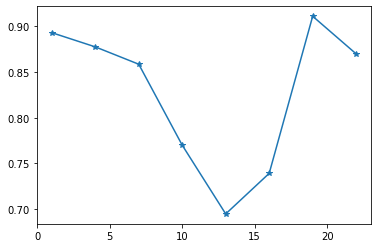

In [172]:
# Test plot...
plt.plot(np.unique(modelTimes_local[1,:].hour)[0:8], modelMean_EFbyClass[0,1,:],'*-')



In [205]:
# What does mean bias look like, averaged across stations? 

absBias_SHbyClass = modelMean_SHbyClass - obsMean_SHbyClass
absBias_LHbyClass = modelMean_LHbyClass - obsMean_LHbyClass
absBias_EFbyClass = modelMean_EFbyClass - obsMean_EFbyClass

absBias_SHbyClass_24hours = np.full([4, len(stationID), 24], np.nan)
absBias_LHbyClass_24hours = np.full([4, len(stationID), 24], np.nan)
absBias_EFbyClass_24hours = np.full([4, len(stationID), 24], np.nan)
model_SHbyClass_24hours   = np.full([4, len(stationID), 24], np.nan)
model_LHbyClass_24hours   = np.full([4, len(stationID), 24], np.nan)
model_EFbyClass_24hours   = np.full([4, len(stationID), 24], np.nan)
obs_SHbyClass_24hours     = np.full([4, len(stationID), 24], np.nan)
obs_LHbyClass_24hours     = np.full([4, len(stationID), 24], np.nan)
obs_EFbyClass_24hours     = np.full([4, len(stationID), 24], np.nan)

for iStation in range(len(stationID)):
    iPlace = np.unique(modelTimes_local[iStation,:].hour)[0:8].astype(int)
    
    absBias_SHbyClass_24hours[:, iStation, iPlace] = absBias_SHbyClass[:,iStation,:]
    absBias_LHbyClass_24hours[:, iStation, iPlace] = absBias_LHbyClass[:,iStation,:]
    absBias_EFbyClass_24hours[:, iStation, iPlace] = absBias_EFbyClass[:,iStation,:]
    
    model_SHbyClass_24hours[:,iStation,iPlace] = modelMean_SHbyClass[:,iStation,:]
    model_LHbyClass_24hours[:,iStation,iPlace] = modelMean_LHbyClass[:,iStation,:]
    model_EFbyClass_24hours[:,iStation,iPlace] = modelMean_EFbyClass[:,iStation,:]
    
    obs_SHbyClass_24hours[:,iStation,iPlace] = obsMean_SHbyClass[:,iStation,:]
    obs_LHbyClass_24hours[:,iStation,iPlace] = obsMean_LHbyClass[:,iStation,:]
    obs_EFbyClass_24hours[:,iStation,iPlace] = obsMean_EFbyClass[:,iStation,:]
    
    
    #plt.plot(np.unique(modelTimes_local[iStation,:].hour)[0:8], modelMean_EFbyClass[0,iStation,:],'*-')


In [206]:
np.shape(model_LHbyClass_24hours)

(4, 114, 24)

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-30.0, 250.0)

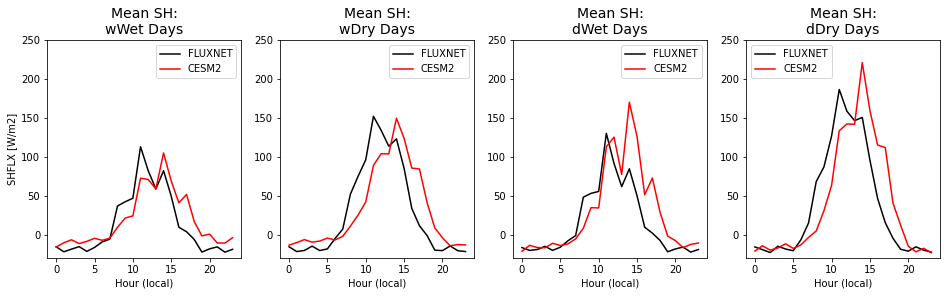

In [219]:
fig, axs = plt.subplots(1,4, figsize=(16, 4))
axs = axs.ravel()

axs[0].plot(np.arange(0,24,1), np.nanmean(obs_SHbyClass_24hours[0,:,:], axis=0), 'k',  label='FLUXNET')
axs[0].plot(np.arange(0,24,1), np.nanmean(model_SHbyClass_24hours[0,:,:], axis=0),'r', label='CESM2')
axs[0].set_title('Mean SH:\n'+classCodes[0]+' Days',fontsize=14)
axs[0].legend()
axs[0].set_xlabel('Hour (local)')
axs[0].set_ylabel('SHFLX [W/m2]')

axs[1].plot(np.arange(0,24,1), np.nanmean(obs_SHbyClass_24hours[1,:,:], axis=0), 'k',  label='FLUXNET')
axs[1].plot(np.arange(0,24,1), np.nanmean(model_SHbyClass_24hours[1,:,:], axis=0),'r', label='CESM2')
axs[1].set_title('Mean SH:\n'+classCodes[1]+' Days',fontsize=14)
axs[1].legend()
axs[1].set_xlabel('Hour (local)')

axs[2].plot(np.arange(0,24,1), np.nanmean(obs_SHbyClass_24hours[2,:,:], axis=0), 'k',  label='FLUXNET')
axs[2].plot(np.arange(0,24,1), np.nanmean(model_SHbyClass_24hours[2,:,:], axis=0),'r', label='CESM2')
axs[2].set_title('Mean SH:\n'+classCodes[2]+' Days',fontsize=14)
axs[2].legend()
axs[2].set_xlabel('Hour (local)')

axs[3].plot(np.arange(0,24,1), np.nanmean(obs_SHbyClass_24hours[3,:,:], axis=0), 'k',  label='FLUXNET')
axs[3].plot(np.arange(0,24,1), np.nanmean(model_SHbyClass_24hours[3,:,:], axis=0),'r', label='CESM2')
axs[3].set_title('Mean SH:\n'+classCodes[3]+' Days',fontsize=14)
axs[3].legend()
axs[3].set_xlabel('Hour (local)')

# Set y-axis limits
axs[0].set_ylim([-30,250])
axs[1].set_ylim([-30,250])
axs[2].set_ylim([-30,250])
axs[3].set_ylim([-30,250])


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-10.0, 200.0)

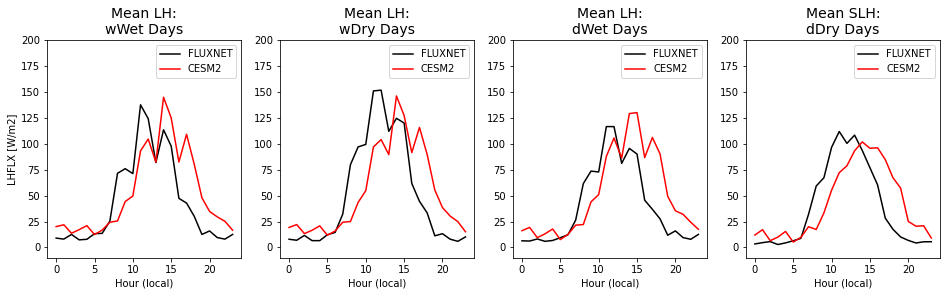

In [221]:
fig, axs = plt.subplots(1,4, figsize=(16, 4))
axs = axs.ravel()

axs[0].plot(np.arange(0,24,1), np.nanmean(obs_LHbyClass_24hours[0,:,:], axis=0), 'k',  label='FLUXNET')
axs[0].plot(np.arange(0,24,1), np.nanmean(model_LHbyClass_24hours[0,:,:], axis=0),'r', label='CESM2')
axs[0].set_title('Mean LH:\n'+classCodes[0]+' Days',fontsize=14)
axs[0].legend()
axs[0].set_xlabel('Hour (local)')
axs[0].set_ylabel('LHFLX [W/m2]')

axs[1].plot(np.arange(0,24,1), np.nanmean(obs_LHbyClass_24hours[1,:,:], axis=0), 'k',  label='FLUXNET')
axs[1].plot(np.arange(0,24,1), np.nanmean(model_LHbyClass_24hours[1,:,:], axis=0),'r', label='CESM2')
axs[1].set_title('Mean LH:\n'+classCodes[1]+' Days',fontsize=14)
axs[1].legend()
axs[1].set_xlabel('Hour (local)')

axs[2].plot(np.arange(0,24,1), np.nanmean(obs_LHbyClass_24hours[2,:,:], axis=0), 'k',  label='FLUXNET')
axs[2].plot(np.arange(0,24,1), np.nanmean(model_LHbyClass_24hours[2,:,:], axis=0),'r', label='CESM2')
axs[2].set_title('Mean LH:\n'+classCodes[2]+' Days',fontsize=14)
axs[2].legend()
axs[2].set_xlabel('Hour (local)')

axs[3].plot(np.arange(0,24,1), np.nanmean(obs_LHbyClass_24hours[3,:,:], axis=0), 'k',  label='FLUXNET')
axs[3].plot(np.arange(0,24,1), np.nanmean(model_LHbyClass_24hours[3,:,:], axis=0),'r', label='CESM2')
axs[3].set_title('Mean SLH:\n'+classCodes[3]+' Days',fontsize=14)
axs[3].legend()
axs[3].set_xlabel('Hour (local)')

# Set y-axis limits
axs[0].set_ylim([-10,200])
axs[1].set_ylim([-10,200])
axs[2].set_ylim([-10,200])
axs[3].set_ylim([-10,200])



/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, 

(-10.0, 10.0)

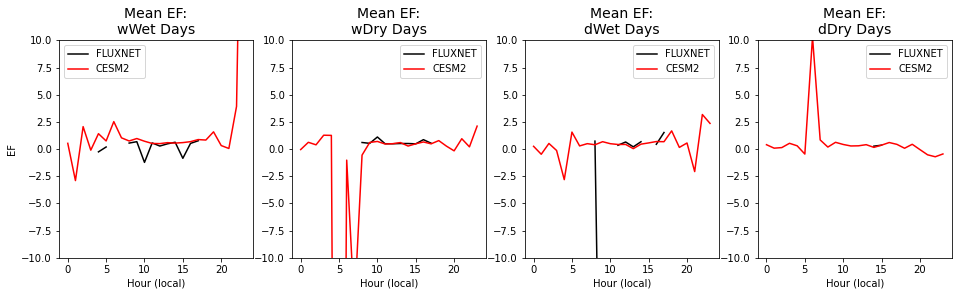

In [224]:
fig, axs = plt.subplots(1,4, figsize=(16, 4))
axs = axs.ravel()

axs[0].plot(np.arange(0,24,1), np.nanmean(obs_EFbyClass_24hours[0,:,:], axis=0), 'k',  label='FLUXNET')
axs[0].plot(np.arange(0,24,1), np.nanmean(model_EFbyClass_24hours[0,:,:], axis=0),'r', label='CESM2')
axs[0].set_title('Mean EF:\n'+classCodes[0]+' Days',fontsize=14)
axs[0].legend()
axs[0].set_xlabel('Hour (local)')
axs[0].set_ylabel('EF')

axs[1].plot(np.arange(0,24,1), np.nanmean(obs_EFbyClass_24hours[1,:,:], axis=0), 'k',  label='FLUXNET')
axs[1].plot(np.arange(0,24,1), np.nanmean(model_EFbyClass_24hours[1,:,:], axis=0),'r', label='CESM2')
axs[1].set_title('Mean EF:\n'+classCodes[1]+' Days',fontsize=14)
axs[1].legend()
axs[1].set_xlabel('Hour (local)')

axs[2].plot(np.arange(0,24,1), np.nanmean(obs_EFbyClass_24hours[2,:,:], axis=0), 'k',  label='FLUXNET')
axs[2].plot(np.arange(0,24,1), np.nanmean(model_EFbyClass_24hours[2,:,:], axis=0),'r', label='CESM2')
axs[2].set_title('Mean EF:\n'+classCodes[2]+' Days',fontsize=14)
axs[2].legend()
axs[2].set_xlabel('Hour (local)')

axs[3].plot(np.arange(0,24,1), np.nanmean(obs_EFbyClass_24hours[3,:,:], axis=0), 'k',  label='FLUXNET')
axs[3].plot(np.arange(0,24,1), np.nanmean(model_EFbyClass_24hours[3,:,:], axis=0),'r', label='CESM2')
axs[3].set_title('Mean EF:\n'+classCodes[3]+' Days',fontsize=14)
axs[3].legend()
axs[3].set_xlabel('Hour (local)')

# Set y-axis limits
axs[0].set_ylim([-10,10])
axs[1].set_ylim([-10,10])
axs[2].set_ylim([-10,10])
axs[3].set_ylim([-10,10])




/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'Hour (local)')

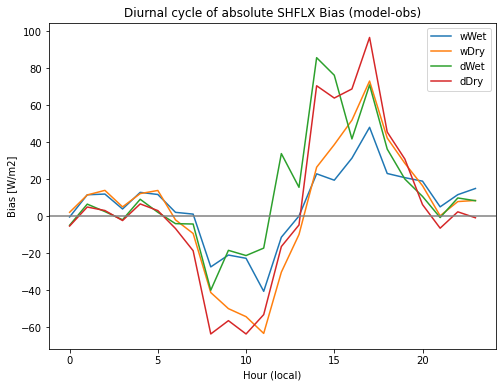

In [198]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.plot(np.arange(0,24,1), np.nanmean(absBias_SHbyClass_24hours[0,:,:], axis=0), label=classCodes[0])
ax1.plot(np.arange(0,24,1), np.nanmean(absBias_SHbyClass_24hours[1,:,:], axis=0), label=classCodes[1])
ax1.plot(np.arange(0,24,1), np.nanmean(absBias_SHbyClass_24hours[2,:,:], axis=0), label=classCodes[2])
ax1.plot(np.arange(0,24,1), np.nanmean(absBias_SHbyClass_24hours[3,:,:], axis=0), label=classCodes[3])

ax1.legend()
ax1.axhline(0,color='gray')
ax1.set_title('Diurnal cycle of absolute SHFLX Bias (model-obs)')
ax1.set_ylabel('Bias [W/m2]')
ax1.set_xlabel('Hour (local)')


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'Hour (local)')

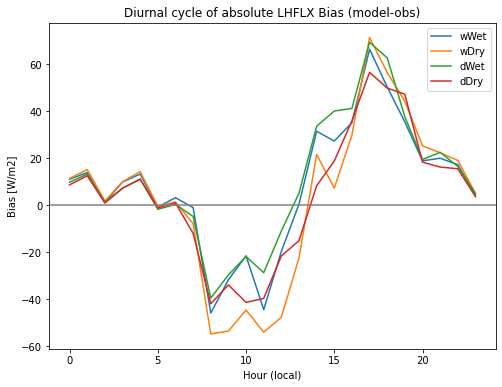

In [197]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.plot(np.arange(0,24,1), np.nanmean(absBias_LHbyClass_24hours[0,:,:], axis=0), label=classCodes[0])
ax1.plot(np.arange(0,24,1), np.nanmean(absBias_LHbyClass_24hours[1,:,:], axis=0), label=classCodes[1])
ax1.plot(np.arange(0,24,1), np.nanmean(absBias_LHbyClass_24hours[2,:,:], axis=0), label=classCodes[2])
ax1.plot(np.arange(0,24,1), np.nanmean(absBias_LHbyClass_24hours[3,:,:], axis=0), label=classCodes[3])

ax1.legend()
ax1.axhline(0,color='gray')
ax1.set_title('Diurnal cycle of absolute LHFLX Bias (model-obs)')
ax1.set_ylabel('Bias [W/m2]')
ax1.set_xlabel('Hour (local)')



/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, 

(0.0, 100.0)

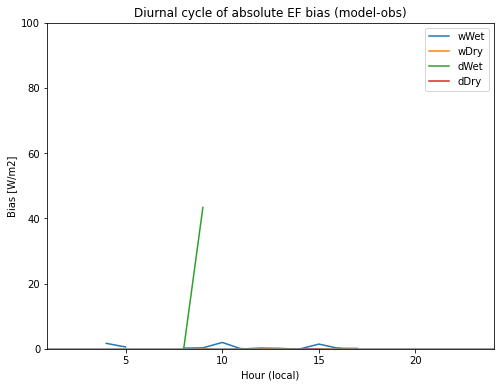

In [202]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.plot(np.arange(0,24,1), np.nanmean(absBias_EFbyClass_24hours[0,:,:], axis=0), label=classCodes[0])
ax1.plot(np.arange(0,24,1), np.nanmean(absBias_EFbyClass_24hours[1,:,:], axis=0), label=classCodes[1])
ax1.plot(np.arange(0,24,1), np.nanmean(absBias_EFbyClass_24hours[2,:,:], axis=0), label=classCodes[2])
ax1.plot(np.arange(0,24,1), np.nanmean(absBias_EFbyClass_24hours[3,:,:], axis=0), label=classCodes[3])

ax1.legend()
ax1.axhline(0,color='gray')
ax1.set_title('Diurnal cycle of absolute EF bias (model-obs)')
ax1.set_ylabel('Bias [W/m2]')
ax1.set_xlabel('Hour (local)')
ax1.set_ylim([0,100])
